<h1 align=center><font size = 5>A/B TESTING</font></h1>

**A/B testing** is a randomized experiment with two variants, A and B. It includes application of statistical hypothesis testing or "two-sample hypothesis testing" as used in the field of statistics.<br>
<br>
In this case, will be working to understand the results of an A/B test run by an e-commerce website. <br>
<br>
The **Goal** is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.<br>
<br>
First step in this content-based filtering is same like others case to Import library that is needed for analyzing and processing the data.

In [0]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm

## Data Description

In [38]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [40]:
df.user_id.nunique()

290584

The total users is 294.477 but the number of unique user is only 290.584. <br>
<br>
It means that there was a data that dont line up between
- treatment = new page
- control = old page

So, we need to clean it.

In [41]:
l = df.query('(group == "treatment" and landing_page != "new_page" ) \
         or (group != "treatment" and landing_page == "new_page")').count()[0]
print("The number of times the new_page and treatment don't line up is {}".format(l))

The number of times the new_page and treatment don't line up is 3893


There was 3893 data that
- treatment = old page
- control = new page

It means that this row isnt truly received the new or old page.<br>
<br>
So, these rows will be drop and create a new dataframe.

In [0]:
df2 =df.drop(df.query('(group == "treatment" and landing_page != "new_page" ) \
                      or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index)

In [43]:
df2.user_id.nunique()

290584

Now the unique users is already clean with 290584 users. Next is checking if there was a data that duplicate.

In [44]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

UserId that have a duplicate raw is 773192.

Checking the duplicate rows

In [45]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Now we want to drop the duplicate data 

In [46]:
df2 = df2.drop(df2.query('user_id == 773192 and timestamp == "2017-01-09 05:37:58.781806"').index)
df2.user_id.duplicated().sum()

0

#### Probability Converting

In [47]:
# Probability of Individual Converting by the Page Received
df_prob =df2.query('converted == 1').user_id.nunique()/df2.user_id.nunique()
df_prob

print("The probability of an individual converting regardless of the page they receive is {0:.2%}".format(df_prob))

The probability of an individual converting regardless of the page they receive is 11.96%


In [48]:
# Probabilty user was in the CONTROL group to convert
p_cont = df2.query('converted == 1 and group == "control"').user_id.nunique() \
/df2.query('group == "control"').user_id.nunique()

print("The probability they converted based on control group is {0:.2%}".format(p_cont))

The probability they converted based on control group is 12.04%


In [49]:
#Probabilty user was in the TREATMENT group to convert
p_treat = df2.query('converted == 1 and group == "treatment"').user_id.nunique() \
/df2.query('group == "treatment"').user_id.nunique()

print("The probability they converted based on treatment group is {0:.2%}".format(p_treat))

The probability they converted based on treatment group is 11.88%


In [50]:
# Calculate the probabilty that an individual received the new page
p_n = df2.query('landing_page == "new_page"').user_id.nunique()/df2.user_id.nunique()
#The probability that an individual received the new page is 50.00%
print("The probability that an individual received the new page is {0:.2%}".format(p_n))

The probability that an individual received the new page is 50.01%


By this probability converting, there was **insufficient evidence  that the new treatment page leads to more conversions than the control page.** Because The difference of probability between control (12.04%) and treatment groups (11.88%) is tiny, especially when we compare them with the probability of individual conversion (11.96%)

## A/B Testing

Since the data still have an insufficient evidence that means the new treatment page leads to more conversions than the control page with probability tests,there will be a hypothesis test continuously as each observation was observed with the time stamp associated with each event.

### Hypothesis

assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypothesis follow below:


* $H_{0}$: $p_{old}$ >= $p_{new}$
* $H_{1}$: $p_{old}$ < $p_{new}$


Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

this process use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [51]:
p_new = df2.converted.mean()
print("The convert rate for p_new under the null is {0:.4}".format(p_new))
p_old = df2.converted.mean()
print("The convert rate for p_old under the null is {0:.4}".format(p_old))

The convert rate for p_new under the null is 0.1196
The convert rate for p_old under the null is 0.1196


Since P_new and P_old both have "true" success rates equally, their converted rate will have the same result.

#### Total Unique Users

In [52]:
n_new = df2.query('landing_page == "new_page" ').count()[0]
n_new

145310

Unique users with **new** design of landing page is 145.310 users

In [53]:
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_old

145274

Unique users with **old** design of landing page is 145.274 users

#### Make A Simoultanous Data

In [54]:
#Simulate n_new transactions with a convertion rate of  p_new under the null. 
#Store these n_new 1's and 0's in new_page_converted

new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
new_page_converted

array([1, 1, 1, ..., 0, 1, 1])

In [55]:
#Simulate n_new transactions with a convert rate of  p_old under the null. 
#Store these  n_new 1's and 0's in old_page_converted

old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
old_page_converted

array([1, 0, 1, ..., 1, 1, 1])

#### Converted Means

Find the difference between p_new and p_old for discovering the difference between p_new and p_old, it is necessary to find out the mean of new_page_converted and old_page_converted

In [56]:
new_page_converted.mean()

0.8790929736425573

In [57]:
old_page_converted.mean()

0.8815548549637238

In [58]:
#diff_conv is the difference between p_new and p_old.
diff_conv = new_page_converted.mean() - old_page_converted.mean()
diff_conv

-0.002461881321166426

The converted mean of old page is higher than converted mean of new page.

#### Simulate Data

Simulate 10,000 p_new - p_old values with random binomial

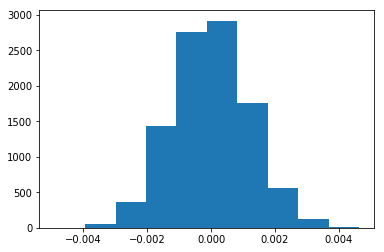

In [61]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

#### Actual difference observed

In [62]:
new_convert = df2.query('converted == 1 and landing_page == "new_page"').count()[0]/n_new
old_convert = df2.query('converted == 1 and landing_page == "old_page"').count()[0]/n_old
obs_diff = new_convert - old_convert
obs_diff

-0.0015782389853555567

#### Proportion Diffs
Check the proportion of the p_diffs are greater than the actual difference observed in ab_data.

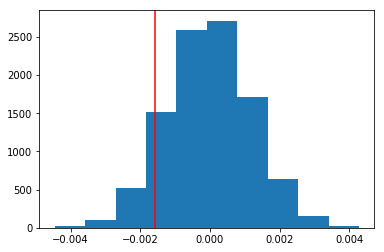

In [63]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red')

In [64]:
(null_vals > obs_diff).mean()

0.9008

### Sampling Distribution Analysis

- The proportion of the conversion rate differences (-0.0024) were greater than the actual observed difference (-0.0015). <br>
The p-value is extremely large (90%) than the type I error rate (5%).That means we fail to reject the null hypothesis.

- In this project, p-value is low (less then 5% = -0.0015), it suggests that the null hypothesis is not true, and it need to consider the alternative hypothesis. Finally, the p-value of 90.08% indicates that **the actual page should be maintained.**


## Z-Test
**stats.proportions_ztest** is used to compute my test statistic and p-value for evaluating if there is a statistically significance difference in conversion rates of the new page and the conversion rates of the old page.

First, calculate the number of conversions for each page, as well as the number of individuals who received each page. The n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [0]:
convert_old = df2.query('converted == 1 and landing_page == "old_page"').count()[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').count()[0]
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_new = df2.query('landing_page == "new_page" ').count()[0]

In [66]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

In [0]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),\
                                              np.array([n_new,n_old]), alternative = 'larger')

In [68]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [69]:
norm.cdf(z_score)

0.09494168724097551

Significant z-score is 0.09494168724097551

In [70]:
norm.ppf(1-(0.05/2))

1.959963984540054

critical value at 95% confidence is 1.959963984540054

#### Z-test Anaylisis

Since the z-score of 1.31 does not exceed the critical value of 1.96, **it fail to reject the null hypothesis.** <br> <br>
**The conversion rates of the old page (17489) >= conversion rates of the new (17264).** <br>
<br>
Moreover, there was not a significant difference between the conversion rates of the new page and the conversion rates of the old page (>0.15%).

## Regression Aproach

The result acheived in the previous A/B test can also be acheived by performing logistic regression that will use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.

In [71]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Create intercept and dummies columns

In [74]:
df2['intercept'] = 1
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


### Create a Model

In [88]:
log = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Sep 2019   Pseudo R-squ.:               8.077e-06
Time:                        08:07:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

### Regression analysis 
The p-value associated with ab_page is 0.19 and the p-value in Part II was 0.90. So, in both cases, we fail to reject the null hyphothesis because these two p-values are greater than 0.05(Type Error I).

## Conclusion

Process that described in this notebook is based on a database providing details on the conversion rate of two groups(treatment group that holds the new page and control group that holds the old page), on an E-commerce platform from 2017-01-02 to 2017-01-24. The goal was to decide whether the E-commerce website should keep the old design or change to a new design for their landing page. <br>
<br>
Regarding the quality of the data, It only 1 row duplicated in a sample with 294,478 rows. So, that problem did not affect the results.<br>
<br>
To achieve the goal, we performed the following tests: A/B test with z-test and logistic regression models. <br>
<br>
* In A/B test, we found the p-value is higher than type error I, and because this, we fail to reject the null hyphotesis.<br>
<br>
* The z-score was 1.31 which does not exceed the critical value of 1.96, so we fail again to reject the null hyphothesis.<br>
<br>

**So the result shows to keep the old design of landing page because it fail to reject the null hypothesis.**